<a href="https://colab.research.google.com/github/Anushkasethi/APS360/blob/main/Impressionist_Art_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Impressionist Art CNN Model**

In [ ]:
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from torch.utils.data.dataloader import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.models as models
from torchvision.utils import save_image

In [ ]:
# Global Variables
classes = ['Cezanne','Degas','Gauguin','Hassam','Matisse','Monet','Pissarro','Renoir','Sargent','VanGogh']

# For reproducible randomness
torch.manual_seed(100)

###Data Processing and Splitting

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
# Mounting to drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_root = "/content/gdrive/MyDrive/all_impressionist_data"

In [ ]:
output_folder = "Impressionist-classifier-data-split"

In [ ]:
splitfolders.ratio(data_root, output_folder, seed = 888, ratio= (0.6, 0.2, 0.2))

Copying files: 4978 files [01:24, 58.85 files/s] 


In [ ]:
# These are Yina's GDrive Paths, I couldn't figure out how to get the path from a shared drive so I uploaded it to my drive manually

### Replace with your own paths if you're running ###
train_path = "./Impressionist-classifier-data-split/train" 
test_path = "./Impressionist-classifier-data-split/test" 
val_path = "./Impressionist-classifier-data-split/val" 

In [ ]:
# We can compose different transforms and tune this, these are the one's I thought to be most relevant
transform_1 = tt.Compose([tt.RandomResizedCrop(224, scale = (0.3, 1.0), ratio = (0.5, 1.9)),
                          tt.ToTensor(),
                          tt.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])

transform_2 = tt.Compose([tt.RandomResizedCrop(224, scale = (0.3, 1.0), ratio = (0.9, 1.1)),
                          tt.ColorJitter(0.5, 0.5, 0.5), 
                          tt.ToTensor(),
                          tt.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])

transform_3 = tt.Compose([tt.RandomResizedCrop(224, scale = (0.3, 1.0), ratio = (0.9, 1.1)),
                          tt.RandomPerspective(0.3, p=1.0),
                          tt.RandomRotation(35),
                          tt.ToTensor(),
                          tt.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])

transform_4 = tt.Compose([tt.RandomResizedCrop(224, scale = (0.3, 1.0), ratio = (0.9, 1.1)), 
                          tt.RandomRotation(35),
                          tt.ToTensor(),
                          tt.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])

In [ ]:
def get_augmented_data(path):
  #dataset_1 = torchvision.datasets.ImageFolder(root = path, transform=transform_1)
  dataset_2 = torchvision.datasets.ImageFolder(root = path, transform=transform_1)
  dataset_3 = torchvision.datasets.ImageFolder(root = path, transform=transform_1)
  #dataset_4 = torchvision.datasets.ImageFolder(root = path, transform=transform_1) #comment out one of these lines if u wanna decrease the size of the train and val sets

  data_concat = torch.utils.data.ConcatDataset([dataset_3, dataset_2]) #, dataset_3, dataset_4]) #remember to take the variable out of here if u comment out something above
  #print(len(data_concat))

  #data_loader = torch.utils.data.DataLoader(data_concat, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True) #I'm gonna be honest Idk what the last two parameters do feel free to change them
  #classes = dataset_1.classes

  return data_concat

In [ ]:
def get_data(path):
  
  dataset = torchvision.datasets.ImageFolder(root = path, transform=transform_1)
  #data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1, shuffle=True)

  return dataset

In [ ]:
# Calling Dataset

train_dataset = get_augmented_data(train_path)
val_dataset = get_data(val_path)
test_dataset = get_data(test_path)

print(len(train_dataset), len(val_dataset), len(test_dataset))

5960 990 1008


###Transfer Learning

In [ ]:
## may or may not be necessary
class transfer(nn.Module):
  def __init__(self):
    super(transfer, self).__init__()
    self.resnet50 = models.resnet50(pretrained=True)

In [ ]:
transfer_net = models.resnet34(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
for i, child in enumerate(transfer_net.children()):
  if i < 7:
    # for the last layer 
    for param in child.parameters():
      param.requires_grad = False

'''
for param in transfer_net.parameters():
  param.requires_grad = False
'''

'\nfor param in transfer_net.parameters():\n  param.requires_grad = False\n'

In [ ]:
#replace the head (fc classifier)

transfer_net.fc = nn.Sequential(
                  nn.Dropout(),
                  nn.Linear(transfer_net.fc.in_features, 200),
                  nn.ReLU(inplace=True),
                  nn.Dropout(),
                  nn.Linear(200, 10),
                  )
'''
transfer_net.fc = nn.Linear(transfer_net.fc.in_features, 10)
'''

'\ntransfer_net.fc = nn.Linear(transfer_net.fc.in_features, 10)\n'

In [ ]:
#train function
def train(model, name, train_set, val_set, lr=0.001, batch_size=64, num_epochs=10):
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=0.00001)
  #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  criterion = nn.CrossEntropyLoss()
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  train_acc, train_loss, val_acc, val_loss = [], [], [], []
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    running_loss = 0
    correct = 0
    total_samples = 0

    for i, samples in enumerate(train_loader, 0):
      img, labels = samples # retrieve data from enumerate

      if use_cuda and torch.cuda.is_available:
        img = img.cuda()
        labels = labels.cuda()
        print(img.shape)
      optimizer.zero_grad()
      output = model(img)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      # update stats
      total_samples += len(labels)
      running_loss += loss.item()

      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
    
    # update epoch stats 
    train_acc.append(float(correct)/total_samples) 
    train_loss.append(float(running_loss)/(i+1)) # average
    val_acc.append(evaluate(model, val_loader, criterion)[0])
    val_loss.append(evaluate(model, val_loader, criterion)[1])
    
    print("Epoch:", epoch+1, "Training acc:", train_acc[-1], ", Train loss:", 
          train_loss[-1], ", Val acc:", val_acc[-1], ", Val loss:", val_loss[-1])
    save_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, lr, epoch)
    torch.save(model.state_dict(), save_path)

  # plotting
  plt.title("Train/Val Loss Curve")
  n = len(train_acc)
  plt.plot(range(1, n+1), train_loss, label="Train")
  plt.plot(range(1, n+1), val_loss, label="Val")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Train/Val Accuracy Curve")
  plt.plot(range(1, n+1), train_acc, label="Train")
  plt.plot(range(1, n+1), val_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))
    

In [ ]:
def evaluate(model, loader, criterion):
    running_loss = 0
    correct = 0
    total_samples = 0

    for i, samples in enumerate(loader, 0):
      img, labels = samples # retrieve data from enumerate

      if use_cuda and torch.cuda.is_available:
        img = img.cuda()
        labels = labels.cuda()
      
      output = model(img)
      loss = criterion(output, labels)

      # update stats
      total_samples += len(labels)
      running_loss += loss.item()
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
    
    # update epoch stats 
    accuracy = float(correct)/total_samples
    loss = float(running_loss)/(i+1)

    return accuracy, loss

In [ ]:
#second try

CUDA is available!  Training on GPU ...
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])


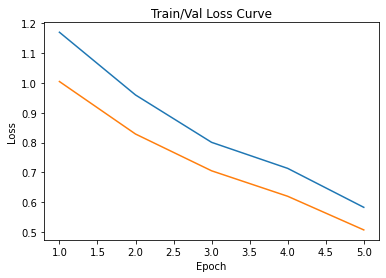

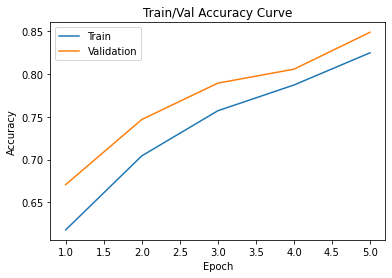

Final Training Accuracy: 0.8246644295302014
Final Validation Accuracy: 0.8486577181208054


In [ ]:
use_cuda = True
model_2 = transfer_net

if use_cuda and torch.cuda.is_available():
  model_2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model_2, "debugging1", train_dataset, val_dataset, lr = 0.001, batch_size = 64, num_epochs=5)

CUDA is available!  Training on GPU ...
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([72, 3, 224, 224])
Epoch: 1 Training acc: 0.8780201342281879 , Train loss: 0.4032685508330663 , Val acc: 0.8984899328859061 , Val loss: 0.36484467176099616
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3

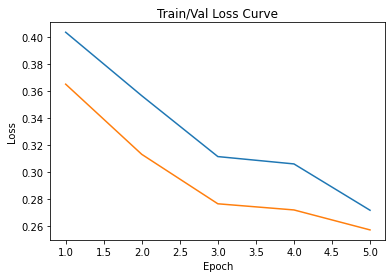

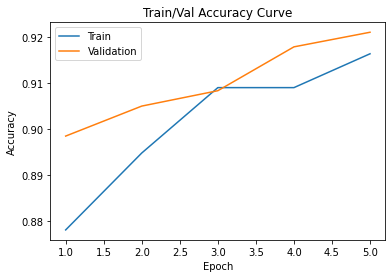

Final Training Accuracy: 0.9164429530201342
Final Validation Accuracy: 0.9211409395973155


In [ ]:
use_cuda = True
model_4 = transfer_net

if use_cuda and torch.cuda.is_available():
  model_4.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model_4, "debugging1", train_dataset, val_dataset, lr = 0.0005, batch_size = 256, num_epochs=5)

CUDA is available!  Training on GPU ...
Epoch: 1 Training acc: 0.7052013422818791 , Train loss: 0.9681591188653986 , Val acc: 0.8083892617449664 , Val loss: 0.6340717628915259
Epoch: 2 Training acc: 0.8320469798657718 , Train loss: 0.5673170590654333 , Val acc: 0.8666107382550335 , Val loss: 0.438126636946455
Epoch: 3 Training acc: 0.864765100671141 , Train loss: 0.43402283305817463 , Val acc: 0.9055369127516778 , Val loss: 0.3164795846381086
Epoch: 4 Training acc: 0.8859060402684564 , Train loss: 0.38192295996432607 , Val acc: 0.8875838926174496 , Val loss: 0.3771388201003379
Epoch: 5 Training acc: 0.9036912751677852 , Train loss: 0.3200380396335683 , Val acc: 0.9315436241610738 , Val loss: 0.23316275471068443


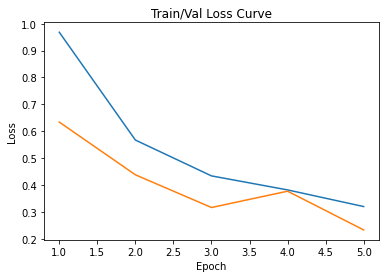

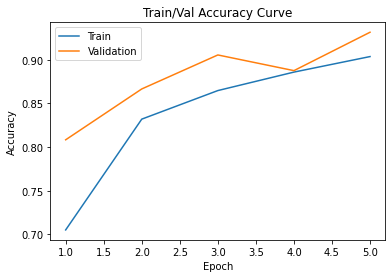

Final Training Accuracy: 0.9036912751677852
Final Validation Accuracy: 0.9315436241610738


In [ ]:
use_cuda = True
model = transfer_net

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, "debugging1", train_dataset, val_dataset, lr = 0.001, batch_size = 128, num_epochs=5)

In [ ]:
# Calling Test Loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
net = transfer_net
model_path = "model_debugging1_bs64_lr0.001_epoch4"
state = torch.load(model_path)
net.load_state_dict(state)

print(evaluate(net, test_loader, nn.CrossEntropyLoss()))

(0.746031746031746, 0.9112714231014252)


In [ ]:
net = transfer_net
model_path = "model_debugging1_bs256_lr0.0005_epoch4"
state = torch.load(model_path)
net.load_state_dict(state)

print(evaluate(net, test_loader, nn.CrossEntropyLoss()))

(0.7966269841269841, 0.7970648482441902)


In [ ]:
net = transfer_net
model_path = "model_debugging1_bs128_lr0.001_epoch3"
state = torch.load(model_path)
net.load_state_dict(state)

print(evaluate(net, test_loader, nn.CrossEntropyLoss()))

(0.7589285714285714, 0.8324983865022659)


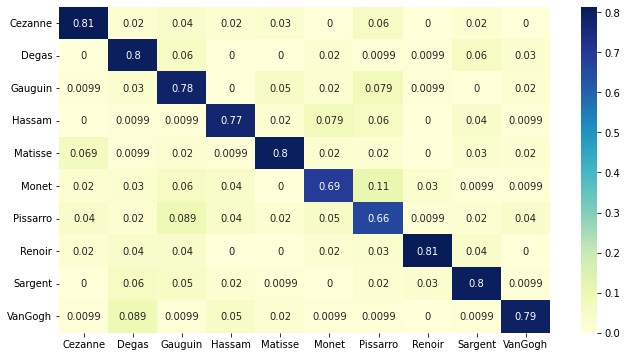

In [ ]:
# Confusion Matrix 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import numpy as np

pred = []
label = []

for img, labels in test_loader:
        if use_cuda and torch.cuda.is_available():
          img = img.cuda()
          labels = labels.cuda()

        output = model(img) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        label.extend(labels) # Save Truth


# confusion matrix
conf_m = confusion_matrix(label, pred)
data = pd.DataFrame(conf_m/np.sum(conf_m) *10, [i for i in classes], [i for i in classes])
plt.figure(figsize = (11,6))
sn.heatmap(data, cmap="YlGnBu", annot=True)
plt.savefig('output.png')